In [11]:
import os
import torch
import torch.nn as nn
from transformer_modules_20_10 import ATM_ViT
import numpy as np
from utils import load_data
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import logging
from tqdm import tqdm

import matplotlib.pyplot as plt
import time

In [12]:
sample_dir = r".\Transformer_debug\sample"
mask_dir = r'.\Transformer_debug\mask'
lr = 2e-4
patch_size=16
pool_size = 10
num_layers = 3 
name = 'transformer_20_10'
device = 'cpu'

In [13]:
model = ATM_ViT(768,num_layers=num_layers).to(device)

In [14]:
#Training
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=.1)

In [15]:
#logger = SummaryWriter(os.path.join("runs", name))
ce_loss = nn.CrossEntropyLoss()

for epoch in range(1):
    if epoch % 10 == 0:
        dataloader = DataLoader(load_data(sample_dir,mask_dir,pool_size), batch_size = 256, shuffle=True)
    pbar = tqdm(dataloader)
    
    for i,(samples,masks) in enumerate(pbar):
        num_patches = masks.shape[-1]//patch_size
        
        samples = samples.to(device)
        masks = masks.to(device)
        sample_patches = samples.unfold(1,patch_size,patch_size).unfold(2,patch_size,patch_size).flatten(-3,-1).flatten(1,2)

        q,attns,class_prediction = model(sample_patches)
        
        fold = nn.Fold((num_patches,num_patches),kernel_size=1)

        total_attn = torch.sum(torch.stack(attns,dim=-1),dim=-1)
        mask = nn.functional.interpolate(fold(total_attn),size=(128,128), mode = 'bilinear',align_corners=False)
        
        semseg = torch.einsum('bq,bqhw->bqhw', class_prediction[..., :-1].mean(dim=1),mask.sigmoid())
        loss = ce_loss(semseg,masks[:,:2,:,:])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix(ce=loss.item())

100%|██████████| 1/1 [00:01<00:00,  1.41s/it, ce=0.116]


torch.Size([3, 3, 64])

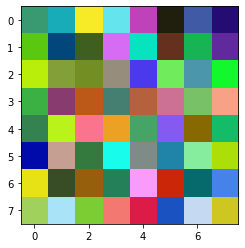

In [16]:
temp1 = torch.rand(3,8,8,3)
plt.imshow(temp1[0])
temp = temp1.unfold(1,1,1).unfold(2,1,1).flatten(-3,-1).flatten(1,2).permute(0,2,1)
temp.shape

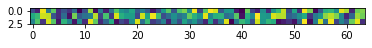

In [17]:
plt.imshow(temp[0])

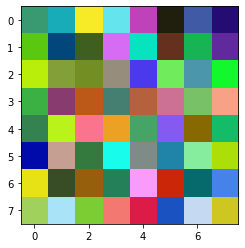

In [18]:
test = fold(temp).permute(0,2,3,1)
plt.imshow(test[0])

In [19]:
data = load_data(sample_dir,mask_dir,pool_size)
eval_samples = data[:][0]

In [20]:
i = np.random.randint(0,len(data))

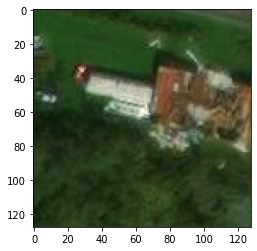

In [21]:
plt.imshow(data[i][0])

In [22]:
eval_samples = eval_samples.to(device)
sample_patches = eval_samples.unfold(1,patch_size,patch_size).unfold(2,patch_size,patch_size).flatten(-3,-1).flatten(1,2)
num_patches = eval_samples.shape[-2]//patch_size

q,attns,class_prediction = model(sample_patches)
        
fold = nn.Fold((num_patches,num_patches),kernel_size=1)

total_attn = torch.sum(torch.stack(attns,dim=-1),dim=-1)
mask = nn.functional.interpolate(fold(total_attn),size=(128,128), mode = 'bilinear',align_corners=False)
semseg = torch.einsum('bq,bqhw->bqhw', class_prediction[..., :-1].mean(dim=1),mask.sigmoid())

In [23]:
temp_mask = mask.sigmoid().permute(0,2,3,1)
temp_class =  class_prediction[..., :-1]


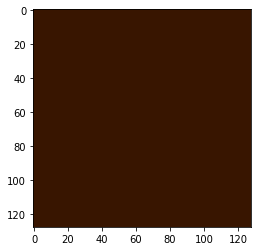

In [24]:
mask_img = semseg[i].permute(1,2,0).cpu().detach().numpy()

mask_img = np.concatenate([mask_img,np.zeros((128,128,1))],axis=-1)
plt.imshow(mask_img)

In [25]:
mask_img

array([[[0.22339468, 0.08542401, 0.        ],
        [0.22339468, 0.08542401, 0.        ],
        [0.22339468, 0.08542401, 0.        ],
        ...,
        [0.22339468, 0.08542401, 0.        ],
        [0.22339468, 0.08542401, 0.        ],
        [0.22339468, 0.08542401, 0.        ]],

       [[0.22339468, 0.08542401, 0.        ],
        [0.22339468, 0.08542401, 0.        ],
        [0.22339468, 0.08542401, 0.        ],
        ...,
        [0.22339468, 0.08542401, 0.        ],
        [0.22339468, 0.08542401, 0.        ],
        [0.22339468, 0.08542401, 0.        ]],

       [[0.22339468, 0.08542401, 0.        ],
        [0.22339468, 0.08542401, 0.        ],
        [0.22339468, 0.08542401, 0.        ],
        ...,
        [0.22339468, 0.08542401, 0.        ],
        [0.22339468, 0.08542401, 0.        ],
        [0.22339468, 0.08542401, 0.        ]],

       ...,

       [[0.22339468, 0.08542401, 0.        ],
        [0.22339468, 0.08542401, 0.        ],
        [0.22339468, 0